## 1. Dataset Description

The dataset is from the Kaggle Competition - [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews). This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all 500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. The data includes 
* Reviews from Oct 1999 - Oct 2012
* 568,454 reviews
* 256,059 users
* 74,258 products
* 260 users with > 50 reviews

Dataset Reference:

1) [From Amateurs to Connoisseurs:Modeling the Evolution of User Expertise through Online Reviews](http://i.stanford.edu/~julian/pdfs/www13.pdf)

2) [Kaggle Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)

In [1]:
import os
import re
import nltk
import swifter
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.stem import (WordNetLemmatizer,
                       SnowballStemmer,
                       LancasterStemmer)

In [2]:
os.chdir('C:/Users/dhava/OneDrive/Desktop/anirudh/course/amazon fine food reviews')
from models.text_clean import CustomTextClean

In [3]:
stop_w = nltk.corpus.stopwords.words('English')
stop_w.remove('no')
stop_w.remove('not')
stop_w.remove('nor')

## 2. Read the dataset


In [4]:
df = pd.read_csv('data/Reviews.csv')

In [5]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


The dataset contains ten columns:
* Id: Row Id
* ProductId:Unique identifier for the product
* UserId: Unqiue identifier for the user
* ProfileName: Profile name of the user
* HelpfulnessNumerator: Number of users who found the review helpful
* HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not
* Score: Rating between 1 and 5
* Time: Timestamp for the review
* Summary: Brief summary of the review
* Text: Text of the review

## 3. Dataset Cleaning

#### 3.1.1 Drop the rows with None

In [6]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
df = df.dropna(axis=0, how='any',inplace=False) 

In [8]:
len(df)

568411

#### 3.2.1 Remove the duplicates

In [9]:
duplicate_df = df[df.duplicated(subset=['ProductId','UserId', 'Time'])]

In [10]:
print("The number of duplicate enteries are: ",len(duplicate_df) )

The number of duplicate enteries are:  4190


In [11]:
duplicate_df[duplicate_df.UserId == 'A15USNEAJUXOSH'].head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
435,436,B000G6RYNE,A15USNEAJUXOSH,L. Schrank,0,0,5,1326067200,Delicious,"I love these chips, I buy the 24 pack once a m..."
26010,26011,B0058AMY74,A15USNEAJUXOSH,L. Schrank,0,0,5,1326067200,Delicious,"I love these chips, I buy the 24 pack once a m..."
56526,56527,B0012XBD7I,A15USNEAJUXOSH,L. Schrank,0,0,5,1326067200,Delicious,"I love these chips, I buy the 24 pack once a m..."


#### 3.2.2 Observations:
* The above records have the same values in all the columns except "Product Id"
* Based on the summary, text and timestamp, the values are all same denoting a duplication

In [12]:
no_duplicates_df = df.drop_duplicates(subset=['ProductId','UserId', 'Time'])

In [13]:
no_duplicates_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [14]:
len(no_duplicates_df)

564221

#### 3.3.1 Illegal Entries
* Check  if the helpfulness numerator is greater than helpfulness denominator
* HelpfulnessNumerator = Number of people who found the review useful
* HelpfulnessDenominator = Number of people who found the review useful + Number of people who found the review not useful
* Hence, HelpfulnessNumerator<=HelpfulnessDenominator
* There are 2 such entries where HelpfulnessNumerator>HelpfulnessDenominator and the entries are illegal

In [15]:
no_duplicates_df[no_duplicates_df.HelpfulnessNumerator > no_duplicates_df.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [16]:
no_illegals_df = no_duplicates_df[no_duplicates_df.HelpfulnessNumerator <= 
                                        no_duplicates_df.HelpfulnessDenominator]

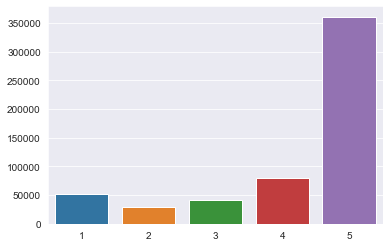

In [17]:
sns.set_style("darkgrid")
val_counts = no_illegals_df['Score'].value_counts().to_dict()
fig = sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.show()

In [18]:
tc = CustomTextClean()

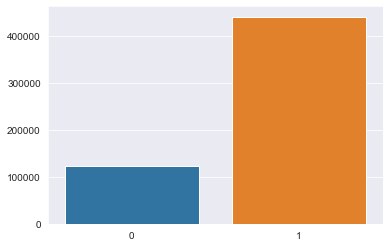

In [19]:
cleaned_df = pd.DataFrame()
cleaned_df['Score'] = no_illegals_df['Score'].apply(lambda x:1 if x>3 else 0)
sns.set_style("darkgrid")
val_counts = cleaned_df['Score'].value_counts().to_dict()
fig = sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.show()

### Observations:
* The data has highest number of reviews with the score of 5.
* The data with rest of the scores are almost have a uniform distribution.
* The scores of 4,5 are considered to be the positive reviews.
* The score of 3 can be considered to be neutral and discarded.
* In this case, we consider the scores of 1,2,3 to be negative.
* The data after this change is again skewed towards the positive class

In [20]:
cleaned_df['Cleaned_Summary'] = no_illegals_df['Summary'].swifter.apply(lambda x: tc.clean(x))

Pandas Apply:   0%|          | 0/564219 [00:00<?, ?it/s]

In [21]:
cleaned_df['Cleaned_Text'] = no_duplicates_df['Text'].swifter.apply(lambda x: tc.clean(x))

Pandas Apply:   0%|          | 0/564221 [00:00<?, ?it/s]

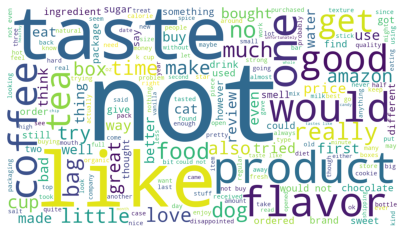

In [22]:
summary_neg = ''.join(cleaned_df[cleaned_df.Score==0]['Cleaned_Summary'].sample(1000, random_state=100).to_list())
text_neg = ''.join(cleaned_df[cleaned_df.Score==0]['Cleaned_Text'].sample(1000, random_state=100).to_list())
tc.plot_wordcloud(text_neg,stop_w)

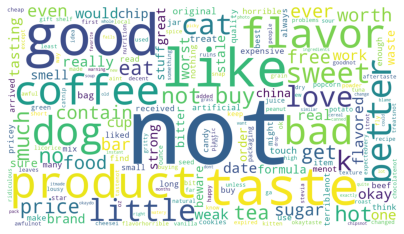

In [23]:
tc.plot_wordcloud(summary_neg,stop_w)

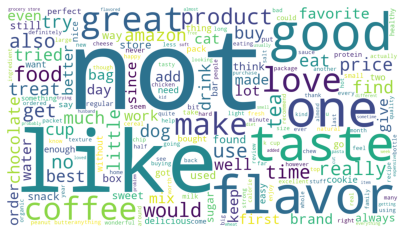

In [24]:
summary_pos= ''.join(cleaned_df[cleaned_df.Score==1]['Cleaned_Summary'].sample(1000, random_state=100).to_list())
text_pos = ''.join(cleaned_df[cleaned_df.Score==1]['Cleaned_Text'].sample(1000, random_state=100).to_list())
tc.plot_wordcloud(text_pos,stop_w)

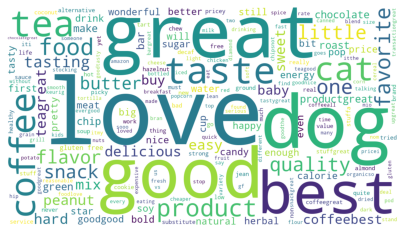

In [25]:
tc.plot_wordcloud(summary_pos)

### Observations from wordcloud:
* The negative wordcloud of the text and summary contains the words like {no, not, bad, etc.,} which would indicate a negative semantic meaning
* The positve wordcloud of the text and summary contains the words like {great, love, like, good, not, etc.,} which would indicate a sematic meaning

In [26]:
texts = cleaned_df['Cleaned_Text'].values

In [33]:
wn = 
()
sl = SnowballStemmer(language='english')
ls = LancasterStemmer()

In [38]:
for text in texts[:3]:
    cd = []
    for word in text.split():
        val = wn.lemmatize(word)
        cd.append(val)
    val = ' '.join(cd)
    print(val)
    print('\n')

i have bought several of the vitality canned dog food product and have found them all to be of good quality the product look more like a stew than a processed meat and it smell better my labrador is finicky and she appreciates this product better than most


product arrived labeled a jumbo salted peanut the peanut were actually small sized unsalted not sure if this wa an error or if the vendor intended to represent the product a jumbo


this is a confection that ha been around a few century it is a light pillowy citrus gelatin with nut in this case filbert and it is cut into tiny square and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sister to the witch




In [39]:
for text in texts[:3]:
    cd = []
    for word in text.split():
        val = sl.stem(word)
        cd.append(val)
    val = ' '.join(cd)
    print(val)
    print('\n')

i have bought sever of the vital can dog food product and have found them all to be of good qualiti the product look more like a stew than a process meat and it smell better my labrador is finicki and she appreci this product better than most


product arriv label as jumbo salt peanut the peanut were actual small size unsalt not sure if this was an error or if the vendor intend to repres the product as jumbo


this is a confect that has been around a few centuri it is a light pillowi citrus gelatin with nut in this case filbert and it is cut into tini squar and then liber coat with powder sugar and it is a tini mouth of heaven not too chewi and veri flavor i high recommend this yummi treat if you are familiar with the stori of c s lewi the lion the witch and the wardrob this is the treat that seduc edmund into sell out his brother and sister to the witch




In [40]:
for text in texts[:3]:
    cd = []
    for word in text.split():
        val = ls.stem(word)
        cd.append(val)
    val = ' '.join(cd)
    print(val)
    print('\n')

i hav bought sev of the vit can dog food produc and hav found them al to be of good qual the produc look mor lik a stew than a process meat and it smel bet my labrad is finicky and she apprecy thi produc bet than most


produc ar label as jumbo salt peanut the peanut wer act smal siz unsalt not sur if thi was an er or if the vend intend to repres the produc as jumbo


thi is a confect that has been around a few century it is a light pillowy citr gelatin with nut in thi cas filbert and it is cut into tiny squ and then lib coat with powd sug and it is a tiny mouth of heav not too chewy and very flav i high recommend thi yummy tre if you ar famili with the story of c s lew the lion the witch and the wardrob thi is the tre that seduc edmund into sel out his broth and sist to the witch


